In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import math
import random
from tqdm import tqdm
import torch as tr
import torch

In [6]:
in_dim = 1
hid_dim = 2
lin1 = torch.rand((in_dim, hid_dim), requires_grad=True)
lin2 = torch.rand((hid_dim, hid_dim), requires_grad=True)
lin3 = torch.rand((hid_dim, in_dim), requires_grad=True)

print(lin1.size())
print(lin2.size())
print(lin3.size())

parameters = torch.cat((lin1.flatten(), lin2.flatten(), lin3.flatten()))
parameters

torch.Size([1, 2])
torch.Size([2, 2])
torch.Size([2, 1])


tensor([0.5188, 0.1347, 0.5556, 0.4210, 0.6127, 0.2680, 0.6565, 0.2025],
       grad_fn=<CatBackward0>)

In [219]:
def make_data(x, target):
    data = []
    if len(x) != len(target):
        assert "Not equal length"
    for i in range(len(x)):
       data += [(x[i], target[i])] 
    return data

def make_points(x0, xn, h_x, y, shuffle = False, noise = False):
    x = np.array([x for x in np.arange(x0, xn + h_x, h_x)], dtype = np.float64)
    target = np.array([y(x) for x in x], dtype = np.float64)
    if noise: 
        noise = np.random.normal(0, 0.1, len(target))
        noise_target = target + noise
    else:
        noise_target = target
    # noise_target = target
    data = make_data(x, noise_target)
    if (shuffle): random.shuffle(data)
    return x, target, noise_target, data

In [220]:
def plot_points(obs=None, times=None, trajs=None, save=None, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    plt.subplot(121)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], color = 'green', label  = 'true')
                # plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], label  = 'true')

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], label = 'pred', lw=2.5, color = 'r')
        if save is not None:
            plt.savefig(save)
    plt.legend()
    plt.subplot(122)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.plot(o[:, b_i, 0], o[:, b_i, 1], color = 'green', label  = 'true')
                # plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], label = 'true')
    plt.legend()
    plt.show()

In [ ]:
import importlib
import odeNet2
importlib.reload(odeNet2)
from odeNet2 import *
import torch as tr
import random as rnd
np.set_printoptions(precision = 5, linewidth = 1000)
tr.set_printoptions(precision = 5, linewidth = 1000, threshold = 10)

def to_np(x):
    return x.detach().clone().cpu().numpy()

def plot_points1(true_values=None, times=None, pred_values=None, x=None, figsize=(8, 4)):
    plt.figure(figsize=figsize)

    x_np = to_np(x)
    plt.subplot(121)
    if true_values is not None:
        y_np =  to_np(true_values)
        plt.scatter(x_np[:, 0], y_np[:, 0], color = 'green', label  = 'true')

    if pred_values is not None:
        y_np = to_np(pred_values)
        plt.scatter(x_np[:, 0], y_np[:, 0], color = 'red', label  = 'pred') 
    plt.legend()
    plt.subplot(122)
    if true_values is not None:
        y_np =  to_np(true_values)
        plt.plot(x_np[:, 0], y_np[:, 0], color = 'green', label  = 'true')

    if pred_values is not None:
        y_np = to_np(pred_values)
        plt.plot(x_np[:, 0], y_np[:, 0], color = 'red', label  = 'pred') 

    plt.legend()
    plt.show()

def make_batch(x_val, y_val, num):
    ind1 = 0
    ind2 = num
    l = []
    for i in range(len(x_val) // num):
        if ind2 >= len(x_val) - 1: break
        if ind1 + 1 == ind2:
            x = x_val[ind1:ind2].view(1, len(x_val[0]))
            y = y_val[ind1:ind2].view(1, len(y_val[0]))
            l += [(x, y)]
        else:
            l += [(x_val[ind1:ind2], y_val[ind1:ind2])]
            
        ind1 = ind2
        ind2 = ind1 + num
    if len(x_val) - (len(x_val) // num) * num != 0:
        l += [(x_val[len(x_val) - num:len(x_val)], y_val[len(x_val) - num:len(x_val)])]
    return l


y1 = lambda x: 2 * x
y2 = lambda x: x**2
y3 = lambda x: -math.sin(x)
y4 = lambda x: math.exp(x - 1) 

def pred(func, xn, ep = 10):

        x, target, noise_target, data = make_points(x0 = 0., xn = xn, h_x = 0.2, y = func, shuffle = False, noise = True)
        # print(x)
        epoch = ep

        l1 = NeuralODE(Matrix_func(1, 8))
        
        z0 = Variable(torch.Tensor([[0.6]]))
        

        # time = np.linspace(0, xn*4, len(x))
        time = np.linspace(0., 10, 10)
        t_values = tr.tensor([[i] for i in time]).type_as(z0)
        # print("t_values : ", t_values)

        y_values = tr.tensor([[j] for i, j in zip(x, noise_target)]).type_as(z0)
        x_values = tr.tensor([[i] for i in x]).type_as(z0)

        optimizer = tr.optim.Adam(l1.parameters(), lr=0.01)
        
        list_batch = make_batch(x_values, y_values, num=10)
        # print(list_batch)

        for i in tqdm(range(epoch)):
            for batch in list_batch:
                x, y = batch
                print(t_values.size())
                z_ = l1(x, t_values, return_whole_sequence=False)

                # print("z_ : ", z_)
                loss = tr.nn.functional.mse_loss(z_, y)

                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()

        zz= []
        tt =[]
        pred_val = tr.zeros(len(x_values), 1).type_as(z0)
        list_batch = make_batch(x_values, y_values, num=1)
        for ind, batch in enumerate(list_batch):
            x, y = batch
            z_ = l1(x, t_values, return_whole_sequence=True)
            zz += [z_]
            tt += [t_values]
            pred_val[ind] = z_[-1]


        plt.figure(figsize=(16, 4))
        plt.subplot(121)
        for z_i, t_i in zip(zz, tt):
            x_np = to_np(t_i)
            y_np = to_np(z_i)
            plt.plot(x_np[:, 0], y_np[:, 0], color = 'blue')
        plt.xlabel('t')
        plt.ylabel('z(t)')

        plt.subplot(122)
        x_np = to_np(x_values)
        y_np = to_np(y_values)
        plt.plot(x_np[:, 0], y_np[:, 0], color = 'green', label  = 'true')
        y_np = to_np(pred_val)
        plt.plot(x_np[:, 0], y_np[:, 0], color = 'red', label  = 'pred') 
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

        
        pred_val = tr.zeros(len(x_values), 1).type_as(z0)
        list_batch = make_batch(x_values, y_values, num=1)
        for ind, batch in enumerate(list_batch):
            x, y = batch
            pred_val[ind] = l1(x, t_values, return_whole_sequence=False)  
        plot_points1(true_values=y_values, times=t_values, pred_values=pred_val.detach(), x = x_values)     
                


param =  136
t_values :  tensor([[0.],
        [4.]])


  0%|          | 0/10 [00:00<?, ?it/s]

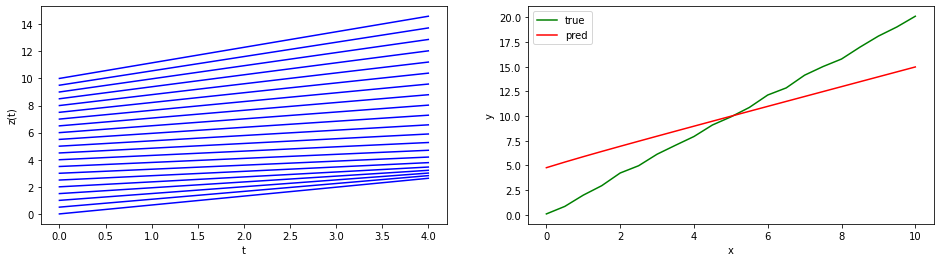

 10%|█         | 1/10 [00:02<00:21,  2.42s/it]

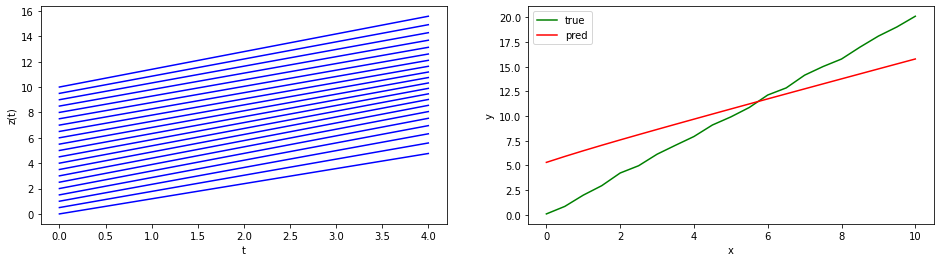

 20%|██        | 2/10 [00:04<00:18,  2.32s/it]

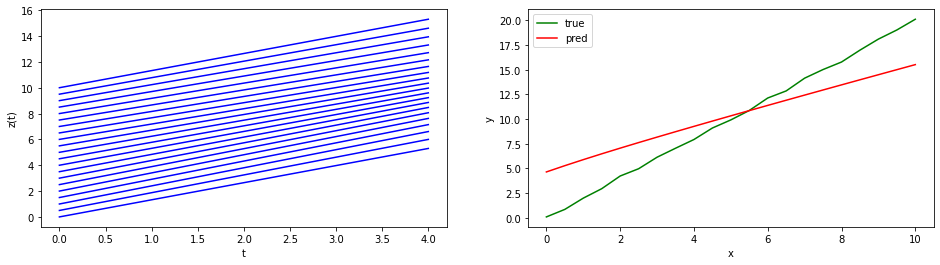

 30%|███       | 3/10 [00:08<00:19,  2.78s/it]

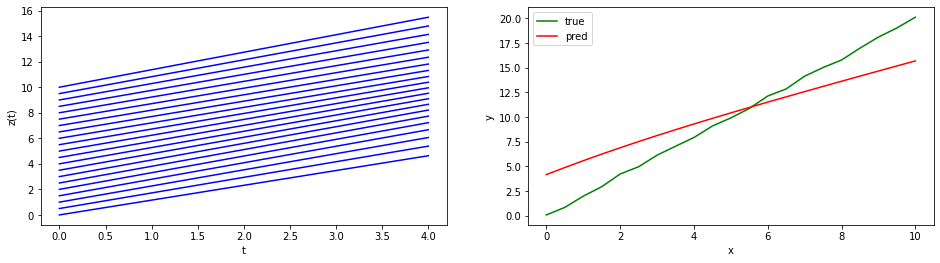

 40%|████      | 4/10 [00:10<00:15,  2.55s/it]

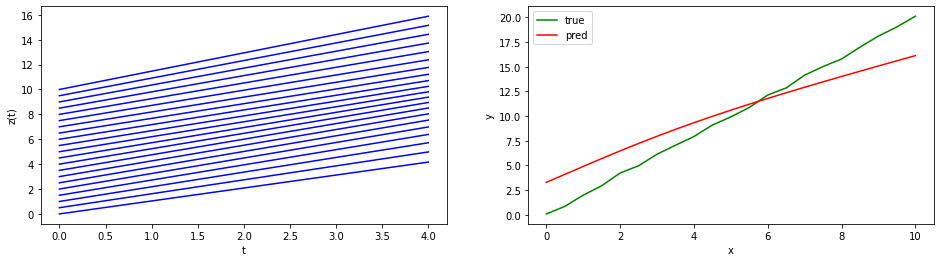

 50%|█████     | 5/10 [00:12<00:12,  2.59s/it]

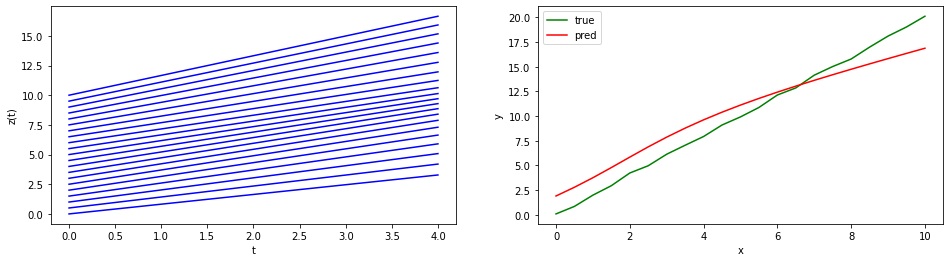

 60%|██████    | 6/10 [00:15<00:10,  2.69s/it]

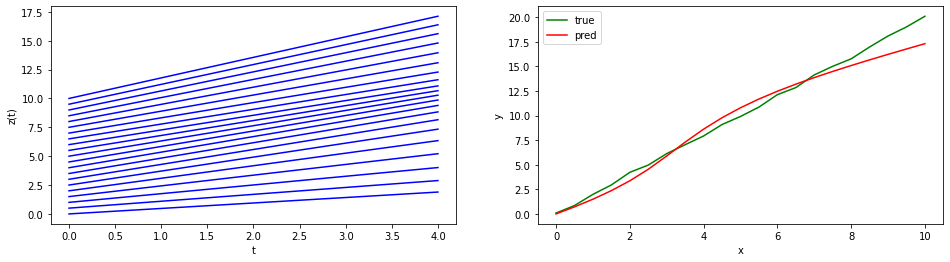

 70%|███████   | 7/10 [00:17<00:07,  2.49s/it]

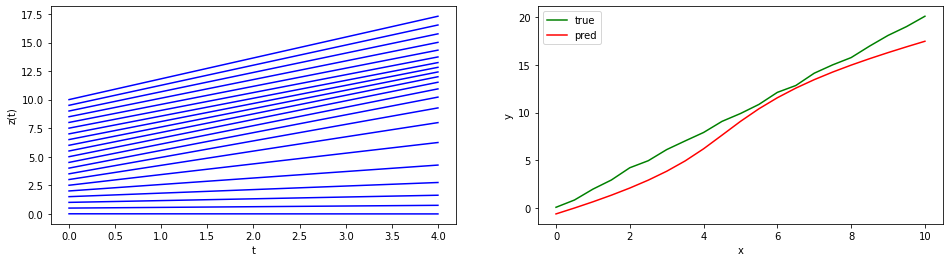

 80%|████████  | 8/10 [00:20<00:05,  2.53s/it]

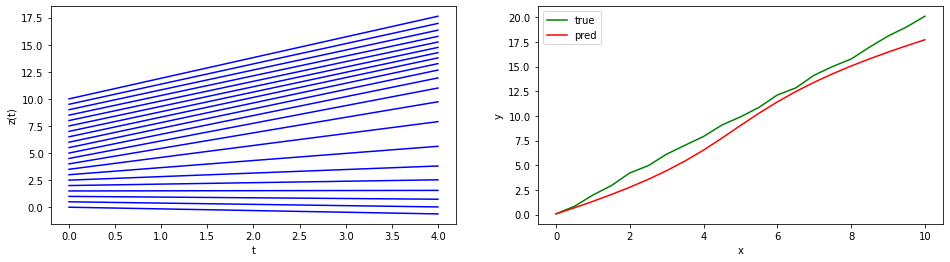

 90%|█████████ | 9/10 [00:23<00:02,  2.63s/it]

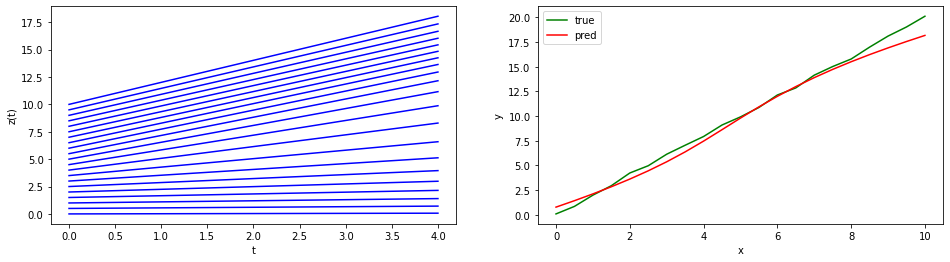

100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


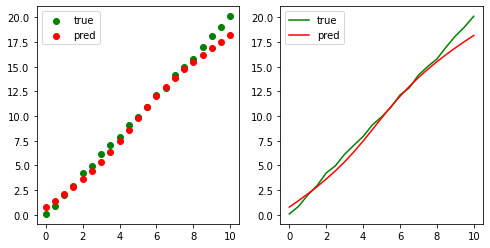

In [167]:
pred(y1, 10.0)

param =  136
t_values :  tensor([[ 0.00000],
        [ 1.11111],
        [ 2.22222],
        ...,
        [ 7.77778],
        [ 8.88889],
        [10.00000]])


100%|██████████| 100/100 [04:48<00:00,  2.89s/it]


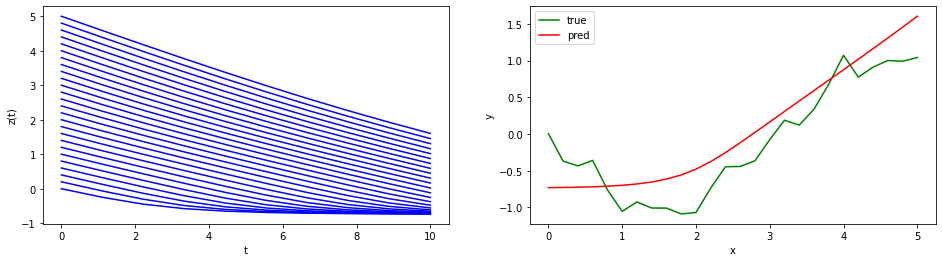

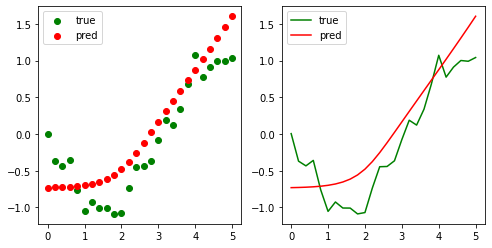

In [217]:
pred(y3, 5.0, ep = 100)

[ 0.04001462 -0.26911479  1.03101988]


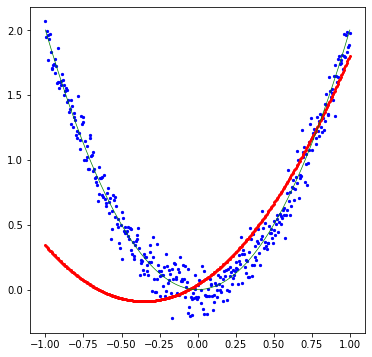


Погрешность решения:  0.3442431884501108


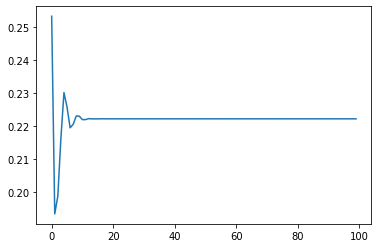

In [ ]:
import importlib
import func
importlib.reload(func)
from func import *

y1 = lambda x: 2 * x**2

h_x = 0.005
x0 = -1
xn = 1

layer = Sq2_Layer(h = 1, lr = 0.01)

x = np.array([x for x in np.arange(x0, xn + h_x, h_x)], dtype = np.float64)
val = np.array([y1(x) for x in x], dtype = np.float64)
noise = np.random.normal(0, 0.1, len(val))

noise_val = val + noise

data = make_data(x, noise_val)
# random.shuffle(data)

ep = 100
ep_losses = [] 
for e in range(ep):
    l = []
    for i in range(len(data)):
        layer.forward(z0 = data[i][0])
        loss = layer.backward(target = data[i][1])
        l += [loss]
    ep_losses += [sum(l) / len(l)]


ans_xy = layer.test(x)
# print(ans_xy)

eps_h = sum((ans_xy[1] - val)**2) / len(val)

print(layer.teta)

Plot2(X_true = x, Y_true = val, xy_noise = np.array(data).T, pred = ans_xy)

print("\nПогрешность решения: ", eps_h)
# plt.plot(np.arange(0, len(layer.losses)), layer.losses);
plt.plot(np.arange(0, len(ep_losses)), ep_losses);


[-0.011266   -0.11028379 -0.01181097 -0.10273343]


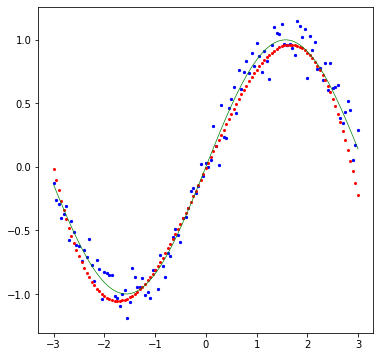


Погрешность решения:  0.007377978926935452


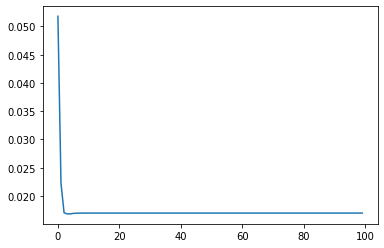

In [ ]:
import importlib
import func
importlib.reload(func)
from func import *

y1 = lambda x: math.sin(x)

h_x = 0.05
x0 = -3
xn = 3

layer = Sq3_Layer(h = 1, lr = 0.01)

x = np.array([x for x in np.arange(x0, xn + h_x, h_x)], dtype = np.float64)
val = np.array([y1(x) for x in x], dtype = np.float64)
noise = np.random.normal(0, 0.1, len(val))

noise_val = val + noise

data = make_data(x, noise_val)
random.shuffle(data)

ep = 100
ep_losses = [] 
for e in range(ep):
    l = []
    for i in range(len(data)):
        layer.forward(z0 = data[i][0])
        loss = layer.backward(target = data[i][1])
        l += [loss]
    ep_losses += [sum(l) / len(l)]


ans_xy = layer.test(x)
# print(ans_xy)

eps_h = sum((ans_xy[1] - val)**2) / len(val)

print(layer.teta)

Plot2(X_true = x, Y_true = val, xy_noise = np.array(data).T, pred = ans_xy)

print("\nПогрешность решения: ", eps_h)
# plt.plot(np.arange(0, len(layer.losses)), layer.losses);
plt.plot(np.arange(0, len(ep_losses)), ep_losses);